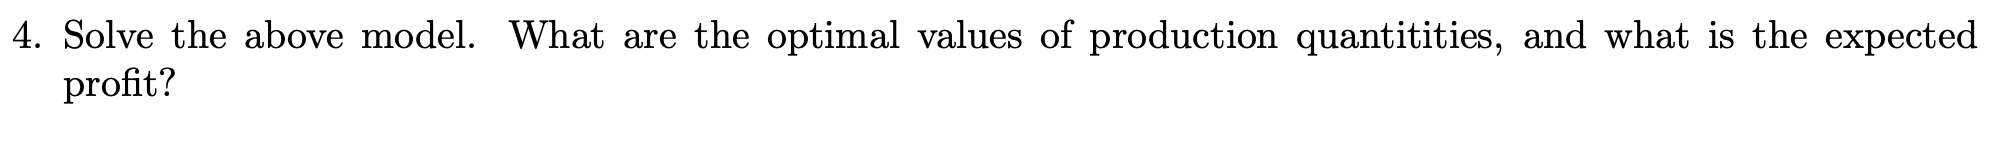

In [1]:
import numpy as np
from pyomo.environ import *
import random

def generate_scenarios(num_scenarios, base_demand):
    scenarios = []
    for _ in range(num_scenarios):
        scenario = {}
        for dc in range(1, 13):
            rand = random.random()
            if rand < 0.3:  # Low demand
                scenario[dc] = base_demand[dc] * 0.7
            elif rand < 0.7:  # Medium demand
                scenario[dc] = base_demand[dc]
            else:  # High demand
                scenario[dc] = base_demand[dc] * 1.3
        scenarios.append(scenario)
    return scenarios

base_demand = {
    1: 20, 2: 30, 3: 40, 4: 35, 5: 15, 6: 19,
    7: 25, 8: 20, 9: 18, 10: 12, 11: 30, 12: 40
}

capacity = {1: 120, 2: 90, 3: 100}
prod_cost = {1: 8, 2: 7, 3: 9}

trans_cost = {
    (1,1):2, (1,2):3, (1,3):2, (1,4):3, (1,5):5, (1,6):4.4, (1,7):3.2, (1,8):3, (1,9):1.5, (1,10):3, (1,11):6.0, (1,12):1.0,
    (2,1):1.9, (2,2):3, (2,3):2.4, (2,4):2.4, (2,5):2, (2,6):4.1, (2,7):2.8, (2,8):3, (2,9):1.7, (2,10):2, (2,11):1.0, (2,12):4.5,
    (3,1):3.1, (3,2):1.8, (3,3):2.8, (3,4):3.4, (3,5):2, (3,6):2.9, (3,7):2.2, (3,8):3.2, (3,9):2, (3,10):2.8, (3,11):4.5, (3,12):6.0
}

num_scenarios = 100  
scenarios = generate_scenarios(num_scenarios, base_demand)
scenario_prob = 1.0 / num_scenarios

model = ConcreteModel()

model.plants = Set(initialize=range(1, 4))
model.dcs = Set(initialize=range(1, 13))
model.scenarios = Set(initialize=range(num_scenarios))

model.y = Var(model.plants, domain=NonNegativeReals)

model.x = Var(model.plants, model.dcs, model.scenarios, domain=NonNegativeReals)
model.u = Var(model.plants, model.scenarios, domain=NonNegativeReals)
model.v = Var(model.dcs, model.scenarios, domain=NonNegativeReals)

def obj_rule(model):
    production_cost = sum(prod_cost[i] * model.y[i] for i in model.plants)
    
    expected_profit = 0
    for s in model.scenarios:
        sales_revenue = 20 * sum(model.x[i,j,s] for i in model.plants for j in model.dcs)
        scrap_revenue = 5 * sum(model.u[i,s] for i in model.plants)
        penalty_cost = 7 * sum(model.v[j,s] for j in model.dcs)
        transport_cost = sum(trans_cost[i,j] * model.x[i,j,s] 
                           for i in model.plants for j in model.dcs)
        
        scenario_profit = sales_revenue + scrap_revenue - penalty_cost - transport_cost
        expected_profit += scenario_prob * scenario_profit
    
    return expected_profit - production_cost

model.objective = Objective(rule=obj_rule, sense=maximize)

def capacity_rule(model, i):
    return model.y[i] <= capacity[i]
model.capacity_const = Constraint(model.plants, rule=capacity_rule)

def flow_balance_rule(model, i, s):
    return sum(model.x[i,j,s] for j in model.dcs) + model.u[i,s] == model.y[i]
model.flow_balance = Constraint(model.plants, model.scenarios, rule=flow_balance_rule)

def demand_rule(model, j, s):
    return sum(model.x[i,j,s] for i in model.plants) + model.v[j,s] == scenarios[s][j]
model.demand_const = Constraint(model.dcs, model.scenarios, rule=demand_rule)

solver = SolverFactory('glpk')
results = solver.solve(model)

print("\nOptimal Production Quantities:")
for i in model.plants:
    print(f"Plant {i}: {value(model.y[i]):.2f}")

print(f"\nExpected Profit: ₹{value(model.objective)*10000:.2f}")

print("\nAverage Scenario Statistics:")
avg_unused = {i: sum(value(model.u[i,s]) for s in model.scenarios)/num_scenarios 
             for i in model.plants}
avg_unmet = {j: sum(value(model.v[j,s]) for s in model.scenarios)/num_scenarios 
            for j in model.dcs}

print("\nAverage Unused Capacity:")
for i in model.plants:
    print(f"Plant {i}: {avg_unused[i]:.2f}")

print("\nAverage Unmet Demand:")
for j in model.dcs:
    print(f"DC {j}: {avg_unmet[j]:.2f}")


Optimal Production Quantities:
Plant 1: 120.00
Plant 2: 90.00
Plant 3: 100.00

Expected Profit: ₹29464536.00

Average Scenario Statistics:

Average Unused Capacity:
Plant 1: 2.44
Plant 2: 0.13
Plant 3: 8.36

Average Unmet Demand:
DC 1: 0.00
DC 2: 0.00
DC 3: 0.00
DC 4: 0.84
DC 5: 0.00
DC 6: 0.20
DC 7: 0.00
DC 8: 3.65
DC 9: 0.00
DC 10: 0.00
DC 11: 0.00
DC 12: 0.00


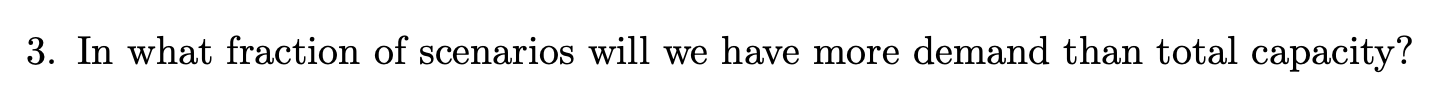

In [2]:
import numpy as np
from scipy import stats

def calculate_dc_variance(medium_demand):
    low = 0.7 * medium_demand
    high = 1.3 * medium_demand
    
    EX2 = 0.3*(low**2) + 0.4*(medium_demand**2) + 0.3*(high**2)
    EX_squared = medium_demand**2
    
    return EX2 - EX_squared

demands = [20, 30, 40, 35, 15, 19, 25, 20, 18, 12, 30, 40]
total_variance = sum(calculate_dc_variance(d) for d in demands)

mu = 304  
sigma = np.sqrt(total_variance)

p_exceed = 1 - stats.norm.cdf(310, mu, sigma)

print(f"Probability of total demand exceeding capacity: {p_exceed:.4f}")
print(f"Fraction of scenarios with demand > capacity: {p_exceed*100:.2f}%")

Probability of total demand exceeding capacity: 0.3910
Fraction of scenarios with demand > capacity: 39.10%


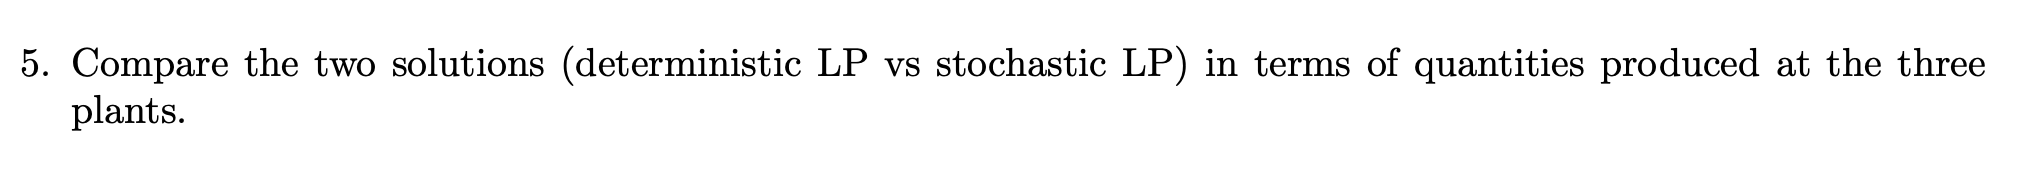

In [1]:
from pyomo.environ import *
import numpy as np

plants = range(1, 4)
dcs = range(1, 13)
capacity = {1: 120, 2: 90, 3: 100}
prod_cost = {1: 8, 2: 7, 3: 9}
selling_price = 20
scrap_value = 5
penalty_cost = 7

trans_cost = {
    (1,1):2, (1,2):3, (1,3):2, (1,4):3, (1,5):5, (1,6):4.4, (1,7):3.2, (1,8):3, (1,9):1.5, (1,10):3, (1,11):6.0, (1,12):1.0,
    (2,1):1.9, (2,2):3, (2,3):2.4, (2,4):2.4, (2,5):2, (2,6):4.1, (2,7):2.8, (2,8):3, (2,9):1.7, (2,10):2, (2,11):1.0, (2,12):4.5,
    (3,1):3.1, (3,2):1.8, (3,3):2.8, (3,4):3.4, (3,5):2, (3,6):2.9, (3,7):2.2, (3,8):3.2, (3,9):2, (3,10):2.8, (3,11):4.5, (3,12):6.0
}

demand = {1:20, 2:30, 3:40, 4:35, 5:15, 6:19, 7:25, 8:20, 9:18, 10:12, 11:30, 12:40}

def solve_deterministic():
    model = ConcreteModel()
    
    model.x = Var(plants, dcs, domain=NonNegativeReals)
    
    def obj_rule(model):
        return sum((selling_price - prod_cost[i] - trans_cost[i,j]) * model.x[i,j] 
                  for i in plants for j in dcs)
    model.objective = Objective(rule=obj_rule, sense=maximize)
    
    def capacity_rule(model, i):
        return sum(model.x[i,j] for j in dcs) <= capacity[i]
    model.capacity = Constraint(plants, rule=capacity_rule)
    
    def demand_rule(model, j):
        return sum(model.x[i,j] for i in plants) == demand[j]
    model.demand = Constraint(dcs, rule=demand_rule)
    
    solver = SolverFactory('glpk')
    solver.solve(model)
    
    prod = {i: sum(value(model.x[i,j]) for j in dcs) for i in plants}
    return prod, value(model.objective)

def solve_stochastic(num_scenarios=100):
    scenarios = []
    for _ in range(num_scenarios):
        scenario = {}
        for dc in dcs:
            rand = np.random.random()
            if rand < 0.3:  
                scenario[dc] = demand[dc] * 0.7
            elif rand < 0.7:  
                scenario[dc] = demand[dc]
            else:  
                scenario[dc] = demand[dc] * 1.3
        scenarios.append(scenario)
    
    model = ConcreteModel()
    
    model.scenarios = range(num_scenarios)
    
    model.y = Var(plants, domain=NonNegativeReals)  
    model.x = Var(plants, dcs, model.scenarios, domain=NonNegativeReals) 
    model.u = Var(plants, model.scenarios, domain=NonNegativeReals)  
    model.v = Var(dcs, model.scenarios, domain=NonNegativeReals) 
    
    def obj_rule(model):
        prod_costs = sum(prod_cost[i] * model.y[i] for i in plants)
        
        scenario_profit = 0
        for s in model.scenarios:
            sales = selling_price * sum(model.x[i,j,s] for i in plants for j in dcs)
            scrap = scrap_value * sum(model.u[i,s] for i in plants)
            penalty = penalty_cost * sum(model.v[j,s] for j in dcs)
            trans = sum(trans_cost[i,j] * model.x[i,j,s] for i in plants for j in dcs)
            scenario_profit += (sales + scrap - penalty - trans) / num_scenarios
            
        return scenario_profit - prod_costs
    
    model.objective = Objective(rule=obj_rule, sense=maximize)
    
    def capacity_rule(model, i):
        return model.y[i] <= capacity[i]
    model.capacity = Constraint(plants, rule=capacity_rule)
    
    def flow_balance_rule(model, i, s):
        return sum(model.x[i,j,s] for j in dcs) + model.u[i,s] == model.y[i]
    model.flow_balance = Constraint(plants, model.scenarios, rule=flow_balance_rule)
    
    def demand_rule(model, j, s):
        return sum(model.x[i,j,s] for i in plants) + model.v[j,s] == scenarios[s][j]
    model.demand = Constraint(dcs, model.scenarios, rule=demand_rule)
    
    solver = SolverFactory('glpk')
    solver.solve(model)
    
    return {i: value(model.y[i]) for i in plants}, value(model.objective)

det_prod, det_profit = solve_deterministic()
stoch_prod, stoch_profit = solve_stochastic()

print("Production Quantities Comparison:")
print("\nDeterministic Solution:")
for i in plants:
    print(f"Plant {i}: {det_prod[i]:.2f}")

print("\nStochastic Solution:")
for i in plants:
    print(f"Plant {i}: {stoch_prod[i]:.2f}")

print("\nProfit Comparison:")
print(f"Deterministic Expected Profit: ₹{det_profit*10000:.2f}")
print(f"Stochastic Expected Profit: ₹{stoch_profit*10000:.2f}")

print("\nDifferences (Stochastic - Deterministic):")
for i in plants:
    diff = stoch_prod[i] - det_prod[i]
    print(f"Plant {i}: {diff:.2f} ({(diff/det_prod[i]*100):.1f}%)")

Production Quantities Comparison:

Deterministic Solution:
Plant 1: 120.00
Plant 2: 90.00
Plant 3: 94.00

Stochastic Solution:
Plant 1: 120.00
Plant 2: 90.00
Plant 3: 100.00

Profit Comparison:
Deterministic Expected Profit: ₹30652000.00
Stochastic Expected Profit: ₹29060607.00

Differences (Stochastic - Deterministic):
Plant 1: 0.00 (0.0%)
Plant 2: 0.00 (0.0%)
Plant 3: 6.00 (6.4%)
